# 0 Outline
1. Data Process Functions or Class, APIs:
    - can input from excel or others.
    - Output 2-D data points.
        - 1th dimention indicates single data point(x,y,z,t,value).
        - 2th dimention indicates the number of data points.
    - Every data point has form (x,y,z,t,value), where x,y,z is spatial corordinate, t is temporal corordinates, and value is function(to be solved) value.
    - be Tensor.
    - can assign accuracy for each number.
    - can assign whether gradient 'on' or 'off'.

2. Model Functions or Class, APIs:
    - models

3. Tool Functions or Class, APIs:
    - train
    - evaulate

4. Visualization Functions or Class, APIs:


关于数据集的一些信息
pass
可能人为取点
- 线段
- 或cube
- 或圆盘

方程形式：
$$
\begin{aligned}
\begin{cases}
u_t(x,t) &= \triangle u(x,t),\quad t\in(0,T],\quad x\in\Omega \subset \mathbf{R}^n \\
u(x,t) &= 0 ,\quad x\in \partial\Omega\times (0,T] \\
u(x,0) &= \sin(x) \quad x\in\Omega
\end{cases}
\end{aligned}
$$

先考虑$\Omega = [0,\pi]$以及时间为$(0,10]$的情形。
此时上述形式的方程有解析解$u(x,t) = \sin(x)\exp(-t)$

# import modules involved

In [43]:
import torch
import pandas
import torch.nn as nn
import collections
import numpy as np
import matplotlib.pyplot as plt
import random

import itertools

In [44]:
def same_seeds(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [45]:
same_seeds(12)

可能有用的种子：1 4 9 11 12 

# Data Functions or Classes.

In [46]:
class DataProcess:
    """
    数据读取与预处理
    主要是数据读取
    流程(以Excel为例)
    1.读取Excel表 (需要Pandas包)
    2.把数据转换成Tensor格式
    3.把数据变成指定形状
        - 二维矩阵
        - 行数代表数据点个数
        - 每一行代表一个数据点，(x,y,z,t,value)
    4.其它要求
        - 区分边界点和内部点
        - 区分训练集和验证集
    """
    def __init__(self,input,output,spatial_dimension):
        pass

    def ReadFromExcel(self,filename):
        pass

# Model Functions or Classes
- model

In [47]:
class HeatEqModel(nn.Module):
    """
    - 确定深度模型
    - 前向函数
    - 需要确定方程的系数
    """
    def __init__(
        self,
        input_size,
        hidden_size,
        output_size,
        depth,
        f_boundary,
        f_ini,
        u_real = None,
        act=torch.nn.Tanh
    ):
        super(HeatEqModel, self).__init__()

        self.f_boundary = f_boundary
        self.f_ini = f_ini
        self.u_real = u_real
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.depth = depth
        self.act = act

        layers = [('input', torch.nn.Linear(self.input_size, self.hidden_size))]
        layers.append(('input_activation', self.act()))
        for i in range(self.depth): 
            layers.append(
                ('hidden_%d' % i, torch.nn.Linear(self.hidden_size, self.hidden_size))
            )
            layers.append(('activation_%d' % i, self.act()))
        layers.append(('output', torch.nn.Linear(self.hidden_size, self.output_size)))

        layerDict = collections.OrderedDict(layers)
        self.layers = torch.nn.Sequential(layerDict)

    def forward(self, x):
        out = self.layers(x)
        return out

# Util Functions or Classes
- train
- evalute

In [48]:
torch.cuda.is_available()

True

In [49]:
class Util_testnorm:
    """
    包括但不限于：
    - 数据的处理过程
      - 数据类型 long float
      - 数据存储位置cpu or gpu
    - 模型的实例化
    - 定义损失函数
    - 定义训练过程
    - 定义evaluate过程
    - 
    """
    def __init__(self,xyt_boundary,xyt_ini,xyt_In,xt_test,Data = None):
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        self.device = device

        self.boundary = xyt_boundary.detach()
        self.initial = xyt_ini.detach()
        self.In = xyt_In.detach()
        self.xt_test = xt_test.detach()

        self.boundary.requires_grad_()
        self.initial.requires_grad_()
        self.In.requires_grad_()
        self.xt_test.requires_grad_()

        print(self.boundary)
        self.data = Data # Data可以视作一张表。
        self.error = 0
        self.loss = 0

        self.model = HeatEqModel(
            input_size=2,
            hidden_size=20,
            output_size=1,
            depth=4,
            f_boundary = lambda x:torch.zeros(x.size()),
            f_ini = lambda x:torch.sin(x),
            u_real = lambda x:torch.sin(x[:,0])*torch.exp(-x[:,1]),
            act=torch.nn.Tanh
        ).to(device)

        self.realvalue = self.model.u_real(self.xt_test).unsqueeze(1)
        self.realvalue_dt = - self.model.u_real(self.xt_test).unsqueeze(1)
        self.realvalue_dx = (torch.cos(self.xt_test[:,0])*torch.exp(-self.xt_test[:,1])).unsqueeze(1)
        self.realvalue_dxdx = - self.model.u_real(self.xt_test).unsqueeze(1)
        
        # 处理数据的过程放到模型外了
        
        self.criterion = torch.nn.MSELoss()
        self.iter = 0
        
        self.optimizer = torch.optim.LBFGS(
            self.model.parameters(), 
            lr=1e-3, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-7, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe",
        )
        
        self.adam1 = torch.optim.Adam(self.model.parameters())
        self.adam2 = torch.optim.Adam(self.model.parameters(),lr = 1e-4)
        
    def loss_func(self):
        self.adam1.zero_grad()
        self.adam2.zero_grad()
        #self.optimizer.zero_grad()

        # 初边值条件产生的loss_data = loss_boundary + loss_ini.

        # loss_boundary MSE()($\triangle T \cdot \vector{x} + \epsilon \sigma (T^4 - T_{\infty}^4)$ - 0).        
        y_predBoundary = self.model(self.boundary)

        dy_predBoundary_dx = torch.autograd.grad(inputs=self.boundary, outputs=y_predBoundary,
                                                 grad_outputs=torch.ones_like(y_predBoundary),
                                                 retain_graph=True,
                                                 create_graph=True)[0][:,0].unsqueeze(1)
        
        dy_predBoundary_dt = torch.autograd.grad(inputs=self.boundary, outputs=y_predBoundary,
                                                 grad_outputs=torch.ones_like(y_predBoundary),
                                                 retain_graph=True,
                                                 create_graph=True)[0][:,1].unsqueeze(1)

        dy_predBoundary_dxdt = torch.autograd.grad(inputs=self.boundary, outputs=dy_predBoundary_dx,
                                                 grad_outputs=torch.ones_like(y_predBoundary),
                                                 retain_graph=True,
                                                 create_graph=True)[0][:,1].unsqueeze(1)
        
        dy_predBoundary_dxx = torch.autograd.grad(inputs=self.boundary, outputs= dy_predBoundary_dx,
                                                 grad_outputs=torch.ones_like(dy_predBoundary_dx),
                                                 retain_graph=True,
                                                 create_graph=True)[0][:,0].unsqueeze(1)
        
        
        loss_boundary = self.criterion(torch.zeros_like(y_predBoundary),y_predBoundary)
        loss_boundary += self.criterion(torch.zeros_like(dy_predBoundary_dx),dy_predBoundary_dx)
        loss_boundary += self.criterion(torch.zeros_like(dy_predBoundary_dt),dy_predBoundary_dt)
        loss_boundary += self.criterion(torch.zeros_like(dy_predBoundary_dxx),dy_predBoundary_dxx)
        loss_boundary += self.criterion(torch.zeros_like(dy_predBoundary_dxdt),dy_predBoundary_dxdt)
        boundary_samples_num = torch.tensor(len(self.boundary)).to("cuda").to(torch.float32).requires_grad_()
        
        loss_boundary = loss_boundary*20./boundary_samples_num

        y_predIni = self.model(self.initial)
        dy_predIni_dx = torch.autograd.grad(inputs=self.initial, outputs=y_predIni,
                                            grad_outputs=torch.ones_like(y_predIni),
                                            retain_graph=True,
                                            create_graph=True)[0][:,0].unsqueeze(1)
        # loss_ini = MSE()(y_predIni,0)
        #print("\n loss_ini\n")
        #print(f"y_predIni{y_predIni}")
        #print(f"torch.full((y_predIni.shape[0],1),0).to(torch.float32){torch.full((y_predIni.shape[0],1),0).to(torch.float32)}")
        loss_ini = self.criterion(y_predIni-torch.sin(self.initial[:,0]).unsqueeze(1),
                                 torch.zeros_like(y_predIni-torch.sin(self.initial[:,0]).unsqueeze(1)).to(torch.float32).to(self.device)
                                 )
        loss_ini += self.criterion(dy_predIni_dx-torch.cos(self.initial[:,0]).unsqueeze(1),
                                   torch.zeros_like(dy_predIni_dx-torch.cos(self.initial[:,0]).unsqueeze(1))
                                   )
        ini_samples_num = torch.tensor(len(self.initial)).to("cuda").to(torch.float32).requires_grad_()
        loss_ini = loss_ini*torch.pi/ini_samples_num
        y_predIn = self.model(self.In)


        dy_predIn_dx = torch.autograd.grad(inputs=self.In, outputs=y_predIn,
                                                 grad_outputs=torch.ones_like(y_predIn),
                                                 retain_graph=True,
                                                 create_graph=True)[0][:,0].unsqueeze(1)
        
        dy_predIn_dt = torch.autograd.grad(inputs=self.In, outputs=y_predIn,
                                                 grad_outputs=torch.ones_like(y_predIn),
                                                 retain_graph=True,
                                                 create_graph=True)[0][:,1].unsqueeze(1)

        dy_predIn_dxdx = torch.autograd.grad(inputs=self.In, outputs=dy_predIn_dx,
                                                 grad_outputs=torch.ones_like(dy_predIn_dx),
                                                 retain_graph=True,
                                                 create_graph=True)[0][:,0].unsqueeze(1)

        #print("\n loss pde \n")
        #print(f"dy_predIn_dt*self.model.specific_heat*self.model.mass_density{dy_predIn_dt*self.model.specific_heat*self.model.mass_density}")
        #print(f"self.model.thermal_conductivity*(dy_predIn_dxdx + dy_predIn_dydy{self.model.thermal_conductivity*(dy_predIn_dxdx + dy_predIn_dydy)}")
        loss_pde = self.criterion(dy_predIn_dt-dy_predIn_dxdx,
                                  torch.zeros_like(y_predIn)
                                  )

        In_samples_num = torch.tensor(len(self.In)).to("cuda").to(torch.float32).requires_grad_()
        loss_ini = loss_pde*10.*torch.pi/In_samples_num

        loss = loss_pde + loss_boundary + loss_ini
        #print(f"loss_boundary{loss_boundary}\nloss_ini{loss_ini}\nloss_pde{loss_pde}")
        loss.backward()

        if self.iter % 100 == 0: 
            print(self.iter, loss.item())
        self.iter = self.iter + 1
#        print(f"realvalue{self.realvalue.size()} realvalue_dt{self.realvalue_dt.size()} realvalue_dx{self.realvalue_dx.size()} realvalue_dxdx{self.realvalue_dxdx.size()}")
        if self.iter == 1:
            test_first_grad = torch.autograd.grad(inputs=self.xt_test, outputs=self.model(self.xt_test),
                                                 grad_outputs=torch.ones_like(self.model(self.xt_test)),
                                                 retain_graph=True,
                                                 create_graph=True)
            test_dx = test_first_grad[0][:,0].unsqueeze(1)
            test_dt = test_first_grad[0][:,1].unsqueeze(1)
            
            DtestDx_first_grad = torch.autograd.grad(inputs=self.xt_test, outputs=test_dx,
                                                 grad_outputs=torch.ones_like(test_dx),
                                                 retain_graph=True,
                                                 create_graph=False)
            test_dxdx = DtestDx_first_grad[0][:,0].unsqueeze(1)

            error = self.criterion(self.realvalue,self.model(self.xt_test))+self.criterion(self.realvalue_dt,test_dt)+self.criterion(self.realvalue_dx,test_dx)+self.criterion(self.realvalue_dxdx,test_dxdx)
            test_samples_num = torch.tensor(len(self.xt_test)).to("cuda").to(torch.float32).requires_grad_()
            error = 10*torch.pi/test_samples_num *error
            self.error = error.unsqueeze(0)

#            print(f"test_dx{test_dx.size()} test_dt{test_dt.size()} test_dxdx{test_dxdx.size()} realvalue{self.realvalue.size()} realvalue_dt{self.realvalue_dt.size()} realvalue_dx{self.realvalue_dx.size()} realvalue_dxdx{self.realvalue_dxdx.size()}")
        else:
            test_first_grad = torch.autograd.grad(inputs=self.xt_test, outputs=self.model(self.xt_test),
                                                 grad_outputs=torch.ones_like(self.model(self.xt_test)),
                                                 retain_graph=True,
                                                 create_graph=True)
            test_dx = test_first_grad[0][:,0].unsqueeze(1)
            test_dt = test_first_grad[0][:,1].unsqueeze(1)
            
            DtestDx_first_grad = torch.autograd.grad(inputs=self.xt_test, outputs=test_dx,
                                                 grad_outputs=torch.ones_like(test_dx),
                                                 retain_graph=True,
                                                 create_graph=False)
            test_dxdx = DtestDx_first_grad[0][:,0].unsqueeze(1)
            
            error = self.criterion(self.realvalue,self.model(self.xt_test))+self.criterion(self.realvalue_dt,test_dt)+self.criterion(self.realvalue_dx,test_dx)+self.criterion(self.realvalue_dxdx,test_dxdx)
            test_samples_num = torch.tensor(len(self.xt_test)).to("cuda").to(torch.float32).requires_grad_()
            error = 10*torch.pi/test_samples_num *error
            self.error = torch.cat((self.error,error.unsqueeze(0)),0)


        if self.iter == 1:
            self.loss = loss.unsqueeze(0)
        else:
            self.loss = torch.cat((self.loss,loss.unsqueeze(0)),0)
        return loss
    
    def train(self):
        for i in range(10000):
            self.adam2.step(self.loss_func)
        #self.optimizer.step(self.loss_func)
    
    def eval_(self):
        self.model.eval()

# 生成数据且测试
- 内部取样点
    - 36个
    - 主方程
- 边界取样点
    - 36个
    - 边界条件
- 初始取样点
    - 36个
    - 初值条件

三种均是均匀取点

In [50]:
x_ini = np.arange(0,np.pi,np.pi/1600)
x_ini = torch.from_numpy(x_ini).unsqueeze(1).to(torch.float32).to("cuda")
t_ini = torch.zeros_like(x_ini)
xt_ini = torch.cat((x_ini,t_ini),1)
xt_ini.requires_grad_()

tensor([[0.0000e+00, 0.0000e+00],
        [1.9635e-03, 0.0000e+00],
        [3.9270e-03, 0.0000e+00],
        ...,
        [3.1357e+00, 0.0000e+00],
        [3.1377e+00, 0.0000e+00],
        [3.1396e+00, 0.0000e+00]], device='cuda:0', requires_grad=True)

In [51]:
t_boundary = np.arange(0,10,10/800)
x_boundary = np.zeros((800,1))
x_boundary = np.concatenate((x_boundary,x_boundary+np.pi),0)
t_boundary = torch.from_numpy(t_boundary).unsqueeze(1).to(torch.float32).to("cuda")
x_boundary = torch.from_numpy(x_boundary).to(torch.float32).to("cuda")
t_boundary = torch.cat((t_boundary,t_boundary),0)
xt_boundary = torch.cat((x_boundary,t_boundary),1)
xt_boundary.requires_grad_()

tensor([[0.0000, 0.0000],
        [0.0000, 0.0125],
        [0.0000, 0.0250],
        ...,
        [3.1416, 9.9625],
        [3.1416, 9.9750],
        [3.1416, 9.9875]], device='cuda:0', requires_grad=True)

In [52]:
x_In = np.arange(0.05,np.pi-0.05,(np.pi-0.1)/40)
t_In = np.arange(0.5,9.5,9/40)
x_In = torch.from_numpy(x_In).to(torch.float32).to("cuda")
t_In = torch.from_numpy(t_In).to(torch.float32).to("cuda")
grid_x,grid_t = torch.meshgrid(x_In,t_In)
grid_x = grid_x.reshape(1640,-1)
grid_t = grid_t.reshape(1640,-1)
xt_In = torch.cat((grid_x,grid_t),1)
xt_In.requires_grad_()

tensor([[0.0500, 0.5000],
        [0.0500, 0.7250],
        [0.0500, 0.9500],
        ...,
        [3.0916, 8.8250],
        [3.0916, 9.0500],
        [3.0916, 9.2750]], device='cuda:0', requires_grad=True)

In [53]:
x_test = np.arange(0,np.pi,np.pi/10)
t_test = np.arange(0,10,10/10)
x_test = torch.from_numpy(x_test).to(torch.float32).to("cuda")
t_test = torch.from_numpy(t_test).to(torch.float32).to("cuda")
grid_x_test,grid_t_test = torch.meshgrid(x_test,t_test)
grid_x_test = grid_x_test.reshape(100,-1)
grid_t_test = grid_t_test.reshape(100,-1)
xt_test = torch.cat((grid_x_test,grid_t_test),1)
xt_test.requires_grad_()

tensor([[0.0000, 0.0000],
        [0.0000, 1.0000],
        [0.0000, 2.0000],
        [0.0000, 3.0000],
        [0.0000, 4.0000],
        [0.0000, 5.0000],
        [0.0000, 6.0000],
        [0.0000, 7.0000],
        [0.0000, 8.0000],
        [0.0000, 9.0000],
        [0.3142, 0.0000],
        [0.3142, 1.0000],
        [0.3142, 2.0000],
        [0.3142, 3.0000],
        [0.3142, 4.0000],
        [0.3142, 5.0000],
        [0.3142, 6.0000],
        [0.3142, 7.0000],
        [0.3142, 8.0000],
        [0.3142, 9.0000],
        [0.6283, 0.0000],
        [0.6283, 1.0000],
        [0.6283, 2.0000],
        [0.6283, 3.0000],
        [0.6283, 4.0000],
        [0.6283, 5.0000],
        [0.6283, 6.0000],
        [0.6283, 7.0000],
        [0.6283, 8.0000],
        [0.6283, 9.0000],
        [0.9425, 0.0000],
        [0.9425, 1.0000],
        [0.9425, 2.0000],
        [0.9425, 3.0000],
        [0.9425, 4.0000],
        [0.9425, 5.0000],
        [0.9425, 6.0000],
        [0.9425, 7.0000],
        [0.9

In [54]:
net = Util_testnorm(xyt_boundary = xt_boundary
           ,xyt_ini=xt_ini
           ,xyt_In=xt_In
           ,xt_test = xt_test)

tensor([[0.0000, 0.0000],
        [0.0000, 0.0125],
        [0.0000, 0.0250],
        ...,
        [3.1416, 9.9625],
        [3.1416, 9.9750],
        [3.1416, 9.9875]], device='cuda:0', requires_grad=True)


In [55]:
net.train()

0 0.00032043480314314365
100 2.9153900413803058e-06
200 1.474690975555859e-06
300 9.290020557273238e-07
400 5.982126367598539e-07
500 3.844758680315863e-07
600 2.508673162537889e-07
700 1.702049985397025e-07
800 1.2207118516016635e-07
900 9.27658092564343e-08
1000 7.412682379026592e-08
1100 6.166479948888082e-08
1200 5.2948760043136645e-08
1300 4.659825236785764e-08
1400 4.1774569581320975e-08
1500 3.794558978142959e-08
1600 3.477211407698633e-08
1700 3.204325693673127e-08
1800 2.9632250431177454e-08
1900 2.746431881917033e-08
2000 2.549683131292113e-08
2100 2.370397744755337e-08
2200 2.2069055916063007e-08
2300 2.057880443828708e-08
2400 1.9222119007622496e-08
2500 1.798868254354602e-08
2600 1.686729866889891e-08
2700 1.5847676948510525e-08
2800 1.4918819957188134e-08
2900 1.407074368131589e-08
3000 1.3293567135974627e-08
3100 1.25785417637303e-08
3200 1.1917333786470863e-08
3300 1.130264237758638e-08
3400 1.0728189003827993e-08
3500 1.0188588639437057e-08
3600 9.679302692688907e-09
3

In [56]:
error_own = net.error.to("cpu").detach().numpy()
np.savetxt('error_owm_1', error_own)

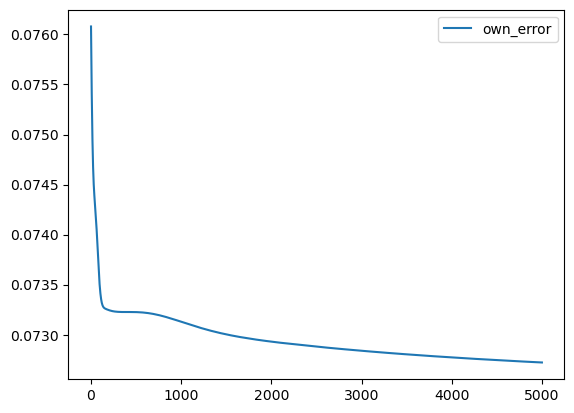

In [57]:
fig, ax = plt.subplots()
x_net = np.arange(0,5000,1)
ax.plot(x_net,error_own[0:5000], label='own_error')
ax.legend()

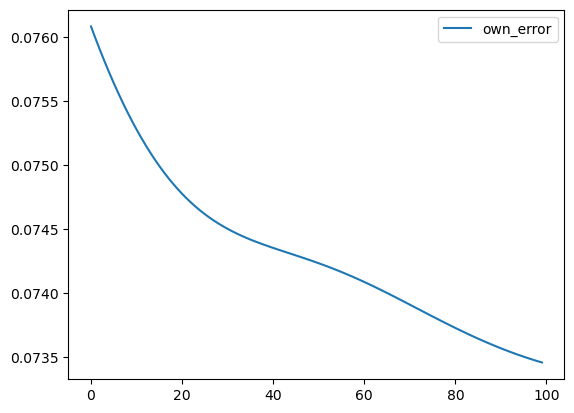

In [58]:
fig, ax = plt.subplots()
x_net = np.arange(0,100,1)
ax.plot(x_net,error_own[0:100], label='own_error')
ax.legend()

In [59]:
loss_own = net.loss.to("cpu").detach().numpy()

In [60]:
error_pinns = np.loadtxt('error_pinns_1')
error_own = np.loadtxt('error_owm_1')

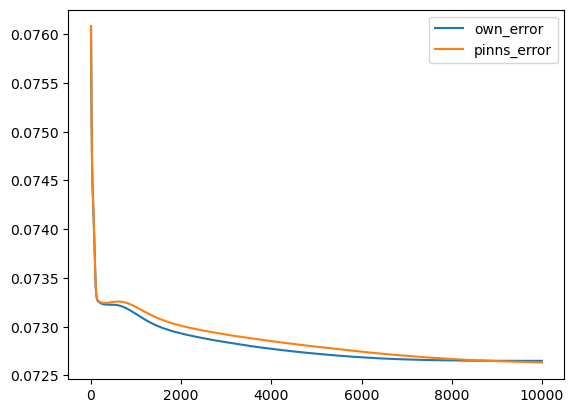

In [69]:
fig, ax = plt.subplots()
x_net = np.arange(0,10000,1)
x_pinns = np.arange(0,10000,1)
ax.plot(x_net,error_own[0:10000], label='own_error')
ax.plot(x_pinns,error_pinns[0:10000], label = 'pinns_error')
ax.legend()

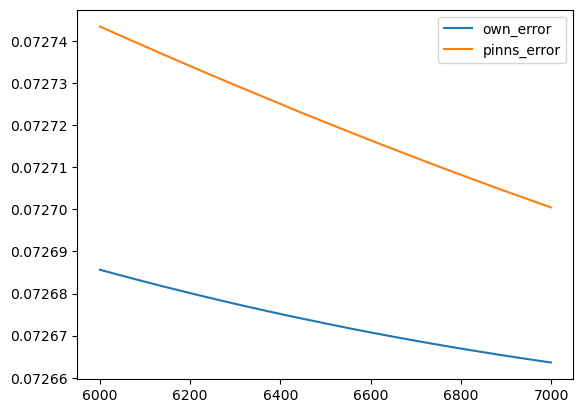

In [62]:
fig, ax = plt.subplots()
x_net = np.arange(6000,7000,1)
x_pinns = np.arange(6000,7000,1)
ax.plot(x_net,error_own[6000:7000], label='own_error')
ax.plot(x_pinns,error_pinns[6000:7000], label = 'pinns_error')
ax.legend()

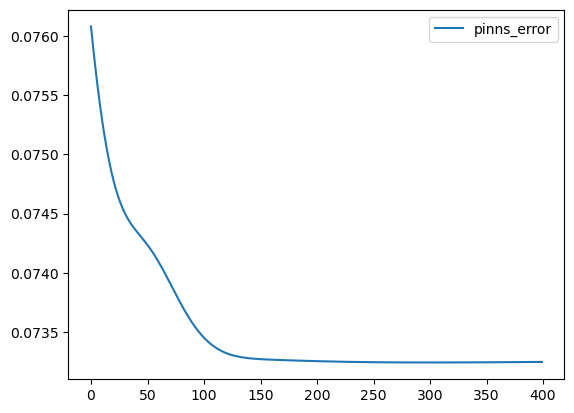

In [63]:
fig, ax = plt.subplots()
x_net = np.arange(0,400,1)
ax.plot(x_net,error_pinns[0:400], label='pinns_error')
ax.legend()

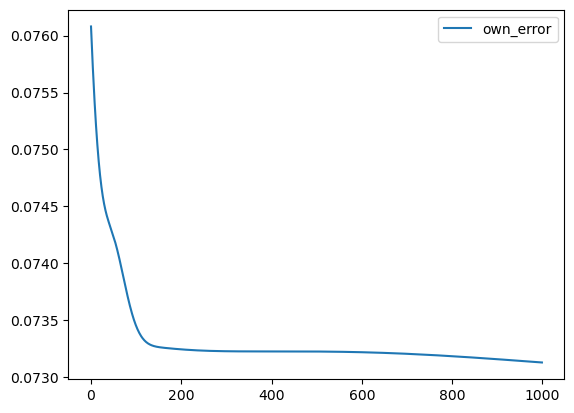

In [64]:
fig, ax = plt.subplots()
x_net = np.arange(0,1000,1)
ax.plot(x_net,error_own[0:1000], label='own_error')
ax.legend()